In [1]:
import time
import tensorflow as tf
import numpy as np
from glob import glob
import datetime
import random
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from  tensorflow import keras
from  tensorflow.keras import layers
import base64
import cv2
import os
from tqdm import tqdm
from tensorflow.keras.utils import img_to_array
import re
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers import LeakyReLU
from keras.layers.core import Flatten, Dropout

SEED=1337

In [ ]:
files = sorted(list(paths.list_images('train')))
print(files)

label = files[0].split(os.path.sep)[1]
print(label)

In [4]:
# initialize the data and labels
print("[INFO] loading images...")
images = []
labels = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images('train')))
random.seed(42)
random.shuffle(imagePaths)

# loop over the input images
for imagePath in imagePaths:
    # load the image, resize it to 64x64 pixels (the required input spatial dimensions of SmallVGGNet), 
    # and store the image in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (224, 224))   # we are not flattening our data for neural network, because it is convolutional
    images.append(image)

    # extract the class label from the image path and update the labels list
    label = imagePath.split(os.path.sep)[1]
    labels.append(label)

# scale the raw pixel intensities to the range [0, 1]
images = np.array(images, dtype="float") / 255.0
labels = np.array(labels)

print('done')

[INFO] loading images...
done


In [5]:
# partition the data into 80% training and 20% validation
(trainX, valX, trainY, valY) = train_test_split(images, labels, test_size=0.2, random_state=SEED)

In [6]:
lb = preprocessing.LabelBinarizer()
trainY = lb.fit_transform(trainY)
valY = lb.transform(valY)

In [7]:
trainX.shape

(3608, 224, 224, 3)

In [8]:
input_shape = (trainX.shape[1], trainX.shape[2], trainX.shape[3])

In [14]:
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers import LeakyReLU
from keras.layers.core import Flatten, Dropout

# https://stackoverflow.com/questions/47143521/where-to-apply-batch-normalization-on-standard-cnns
# https://arxiv.org/abs/1502.03167
# https://www.analyticsvidhya.com/blog/2021/01/building-a-cnn-model-with-95-accuracy/

# dropout increases training time: https://stats.stackexchange.com/questions/376993/why-does-dropout-increase-the-training-time-per-epoch-in-a-neural-network

model = Sequential()   
model.add(Conv2D(64, (3, 3), padding="same", activation="relu", input_shape=input_shape))
model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(BatchNormalization())   

model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))  
model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))  
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())  

model.add(Conv2D(256, (3, 3), padding="same", activation="relu"))  
model.add(Conv2D(256, (3, 3), padding="same", activation="relu"))  
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())  

model.add(Flatten())
model.add(Dense(128, activation="relu"))
#model.add(Activation("relu")) 
model.add(BatchNormalization()) 

# sigmoid classifier
model.add(Dense(1)) # 1 output
model.add(Activation("sigmoid"))

In [10]:
# Construct & initialize the image data generator for data augmentation
# Image augmentation allows us to construct “additional” training data from our existing training data 
# by randomly rotating, shifting, shearing, zooming, and flipping. This is to avoid overfitting.
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True)

### View augmented image

(1080, 1920, 3)
(1, 1080, 1920, 3)


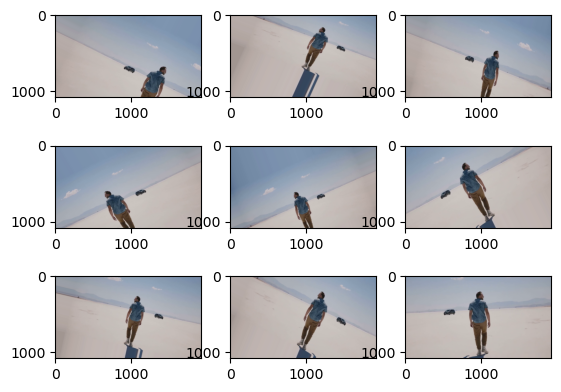

In [11]:
# example of horizontal shift image augmentation
# reference : https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
from numpy import expand_dims
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img('test/norm/A0260551M_20220904_normal_1278_220.png')
# convert to numpy array
data = img_to_array(img)  # TODO: resize 224 224 3
print(data.shape)
# expand dimension to one sample
samples = expand_dims(data, 0)
print(samples.shape)
# create image data augmentation generator
datagen = aug
# prepare iterator
it = datagen.flow(samples, batch_size=2)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [15]:
# compile & train model
# initialize our initial learning rate, # of epochs to train for, and batch size
INIT_LR = 0.001
EPOCHS = 30
BS = 32

# initialize the model and optimizer (you'll want to use binary_crossentropy for 2-class classification)
print("[INFO] training network...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
H = model.fit( aug.flow(trainX, trainY, batch_size=BS),
                        validation_data=(valX, valY), steps_per_epoch=len(trainX) // BS, epochs=EPOCHS,
                        callbacks=[keras.callbacks.EarlyStopping(patience=11, verbose=1, restore_best_weights=True),
                                   keras.callbacks.ReduceLROnPlateau(factor=.5, patience=4, verbose=1)] )

[INFO] training network...


/Users/jiayaoli/miniforge3/envs/py392/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30


2023-04-14 11:25:08.078527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


112/112 [==============================] - ETA: 0s - loss: 0.7116 - accuracy: 0.6689

2023-04-14 11:27:30.150525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


112/112 [==============================] - 355s 3s/step - loss: 0.7116 - accuracy: 0.6689 - val_loss: 0.7189 - val_accuracy: 0.5765 - lr: 0.0010
Epoch 2/30
112/112 [==============================] - 146s 1s/step - loss: 0.5366 - accuracy: 0.7464 - val_loss: 0.6686 - val_accuracy: 0.5876 - lr: 0.0010
Epoch 3/30
112/112 [==============================] - 145s 1s/step - loss: 0.4656 - accuracy: 0.7855 - val_loss: 0.6785 - val_accuracy: 0.6585 - lr: 0.0010
Epoch 4/30
112/112 [==============================] - 512s 5s/step - loss: 0.4332 - accuracy: 0.8082 - val_loss: 0.5569 - val_accuracy: 0.7339 - lr: 0.0010
Epoch 5/30
112/112 [==============================] - 709s 6s/step - loss: 0.4067 - accuracy: 0.8231 - val_loss: 0.3911 - val_accuracy: 0.8137 - lr: 0.0010
Epoch 6/30
112/112 [==============================] - 864s 8s/step - loss: 0.3674 - accuracy: 0.8428 - val_loss: 1.0367 - val_accuracy: 0.5599 - lr: 0.0010
Epoch 7/30
112/112 [==============================] - 159s 1s/step - loss: 

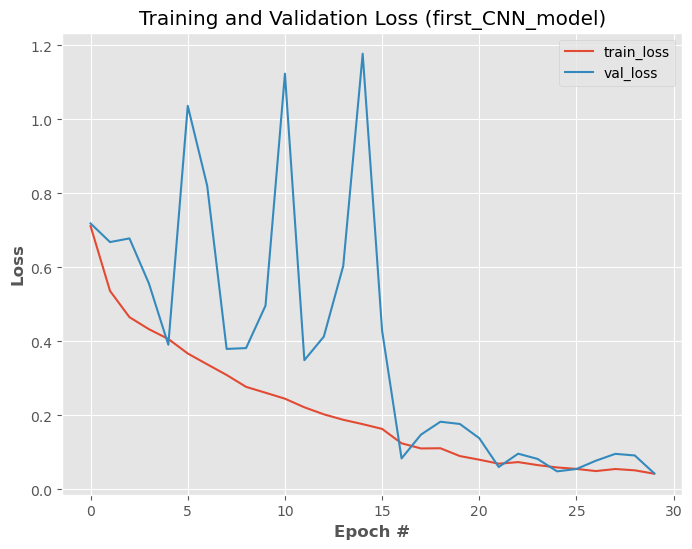

In [20]:
# plot the training/validation loss
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [8,6])
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss (first_CNN_model)")
plt.xlabel("Epoch #", weight='bold')
plt.ylabel("Loss", weight='bold')
plt.legend()

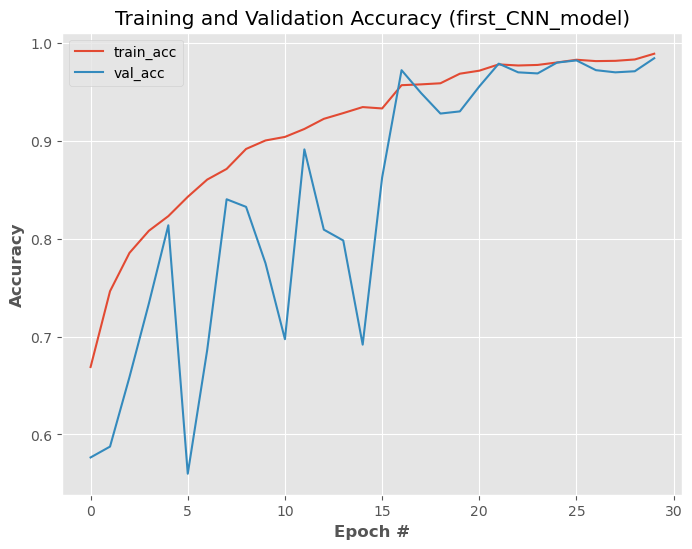

In [21]:
# plot the training/validation accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [8,6])
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy (first_CNN_model)")
plt.xlabel("Epoch #", weight='bold')
plt.ylabel("Accuracy", weight='bold')
plt.legend()

In [16]:
print("[INFO] loading test images...")
testData = []
testLabel = []

# grab the image paths and randomly shuffle them
testImagePaths = sorted(list(paths.list_images('test')))
random.seed(42)
random.shuffle(testImagePaths)

# loop over the input images
for imagePath in testImagePaths:
    # load the image, resize it to 64x64 pixels (the required input spatial dimensions of SmallVGGNet), 
    # and store the image in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (224, 224))   # we are not flattening our data for neural network, because it is convolutional
    testData.append(image)

    # extract the class label from the image path and update the labels list
    label = imagePath.split(os.path.sep)[1]
    testLabel.append(label)

# scale the raw pixel intensities to the range [0, 1]
testData = np.array(testData, dtype="float") / 255.0
testLabel = np.array(testLabel)

print('done')

[INFO] loading test images...
done


In [17]:
testLabel = lb.transform(testLabel)
res = model.predict(testData, batch_size=32)
res = (res>0.5)

 1/64 [..............................] - ETA: 28s

2023-04-14 15:38:55.229154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 24s 369ms/step


In [18]:
print(classification_report(testLabel, res))

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1271
           1       0.64      0.66      0.65       775

    accuracy                           0.73      2046
   macro avg       0.71      0.72      0.71      2046
weighted avg       0.73      0.73      0.73      2046



In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(valY, res))

In [19]:
model.save("cnn_test_accuracy_73.h5")